# Подготовка

## download data

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
get_ipython().system_raw("unrar x PH2Dataset.rar")

## Преобразуем данные

In [2]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])
print(len(tr), len(val), len(ts))

100 50 50


## Сделаем Dataloaders

In [6]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
ds_dict = {'train': data_tr,
           'valid': data_val,
           'test_': data_ts}

## Imports

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

# MainCode

## SegNet

In [11]:
class ConvNormBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last_block=False):
        super().__init__()
        self.is_last_block = is_last_block

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if not self.is_last_block:
            x = self.relu(x)
        return x

In [12]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        #channels = 16
        self.enc_conv0 = ConvNormBlock(3, 16)
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = ConvNormBlock(16, 32)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = ConvNormBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = ConvNormBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = ConvNormBlock(128, 128)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = ConvNormBlock(128, 64)

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = ConvNormBlock(64, 32)

        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = ConvNormBlock(32, 16)

        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = ConvNormBlock(16, 1, is_last_block=True)

    def forward(self, x):
        # encoder
        e, poll_ind0 = self.pool0(self.enc_conv0(x))
        e, poll_ind1 = self.pool1(self.enc_conv1(e))
        e, poll_ind2 = self.pool2(self.enc_conv2(e))
        e, poll_ind3 = self.pool3(self.enc_conv3(e))

        # bottleneck <1>
        b = self.bottleneck_conv(e)

        # decoder
        d = self.dec_conv0(self.upsample0(b, indices=poll_ind3))
        d = self.dec_conv1(self.upsample1(d, indices=poll_ind2))
        d = self.dec_conv2(self.upsample2(d, indices=poll_ind1))
        d = self.dec_conv3(self.upsample3(d, indices=poll_ind0))  # no activation
        return torch.sigmoid(d)

## Score model

In [19]:
class Smoother(nn.Module):
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold

    def forward(self, x):
        binary_image = (x > self.threshold).float()

        # Определение структурого элемента (3x3 окно)
        kernel = torch.ones(1, 1, 3, 3).to(x.device)

        # Применение операции свертки для подсчета суммы значений в 3x3 окрестности
        neighbor_sum = F.conv2d(binary_image, kernel, padding=1)

        # Создание маски: пиксели, у которых сумма в окрестности >= 3, становятся белыми
        mask = (neighbor_sum >= 7).float()

        # Применение маски к бинарному изображению
        filtered_image = binary_image * mask

        return filtered_image


In [20]:
def score_model(model, metric, data, treshold=0.5, show_plots=True, smooth_amout=0):
    #3#
    smooth_it = Smoother()

    X_val, Y_val = next(iter(data))
    model.eval()  # testing mode
    with torch.no_grad():
        Y_hat = model(X_val.to(device)).cpu().detach()

    Y_hat = Y_hat > 0.5
    for i in range(smooth_amout):
        Y_hat = smooth_it(Y_hat)


    if show_plots:
    # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Pred')
            plt.axis('off')

            plt.subplot(4, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('True')
            plt.axis('off')

            plt.subplot(4, 6, k+19)
            plt.imshow(Y_val[k, 0].byte() & Y_hat[k, 0].byte(), cmap='gray')
            plt.title('Intersec')
            plt.axis('off')
        #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    #3#
    model.eval()  # переводим модель в режим тестирования
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            # Отправляем данные на устройство (GPU, если доступно)
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            # Прямой проход (forward pass) для получения предсказаний
            Y_pred = model(X_batch) > treshold # treshold to binarize matrix
            for i in range(smooth_amout):
                Y_pred = smooth_it(Y_pred)
            # Вычисляем метрику на текущем батче и суммируем

            scores += metric(Y_label, Y_pred).mean().item()

    # Возвращаем усредненную метрику по всем батчам
    return scores / len(data)

## Functios

In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    #print(iou)

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

In [49]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, show_plots=True):
    losses = []
    val_acc = []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward

            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        losses.append(loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).cpu().detach()


        # Visualize tools
        clear_output(wait=True)
        if show_plots:
            
            for k in range(6):
                plt.subplot(4, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(4, 6, k+7)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Pred')
                plt.axis('off')

                plt.subplot(4, 6, k+13)
                plt.imshow(Y_val[k, 0], cmap='gray')
                plt.title('True')
                plt.axis('off')

                plt.subplot(4, 6, k+19)
                plt.imshow(Y_val[k, 0].byte() & Y_hat[k, 0].byte(), cmap='gray')
                plt.title('Intersec')
                plt.axis('off')
            #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            plt.show()

        val_score = score_model(model, iou_pytorch, data_val, show_plots=False)
        print('val score', val_score)
        val_acc.append(val_score)
        #print('val_acc', val_acc)
    return losses, val_acc

In [15]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [54]:
def show_plot(data: torch.Tensor, title: str, xlabel: str, ylabel: str):
    for i in range(len(data)):
        data[i] = float(data[i])
        
    plt.figure(figsize=(9, 3))
    plt.grid(True)
    plt.plot(data)
    # Добавляем заголовок и метки осей
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Отображаем график
    plt.show()

In [28]:
def model_full_score(model, ds_dict, treshold=0.5, show_plots=True, smooth_amout=0):
    for ds_name, ds in ds_dict.items():
        score = score_model(model,
                            iou_pytorch,
                            ds,
                            show_plots=show_plots,
                            smooth_amout=smooth_amout)
        print(ds_name, f"{score:.4f}")

## BCELoss

In [21]:
def bce_loss(y_real, y_pred):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))

    # Усредняем потери по всем примерам
    loss = torch.mean(loss)

    return loss

## Dice Loss

In [22]:
def dice_loss(y_real, y_pred):
    smooth =  1e-8
    num = 2 * (y_real * y_pred).sum()
    den = y_real.sum() + y_pred.sum()
    res = 1 - 1/(256*256) * ((num + smooth) / (den + smooth))
    return res

# Обучение

## SegNet + bceloss

### lr=3e-4
### epo=150

In [31]:
model = SegNet().to(device)

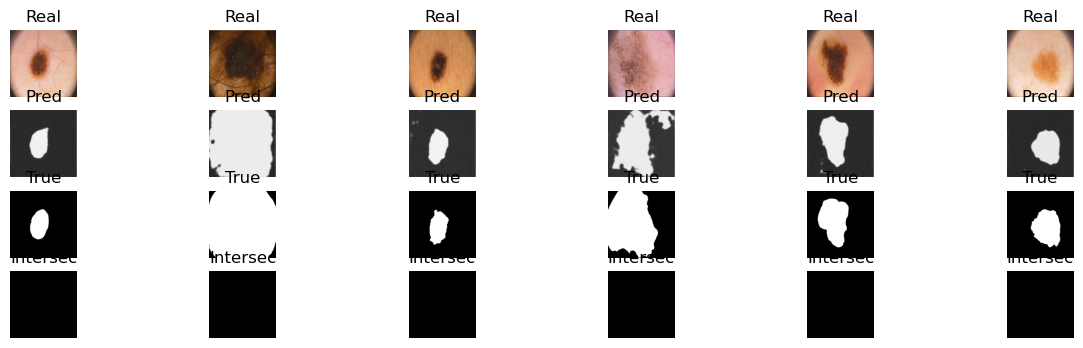

val score 0.7119999527931213


In [33]:
max_epochs = 150
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
losses, val_scores = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [34]:
model_full_score(model, ds_dict, show_plots=False, smooth_amout=0)

train 0.9370
valid 0.7120
test_ 0.7320


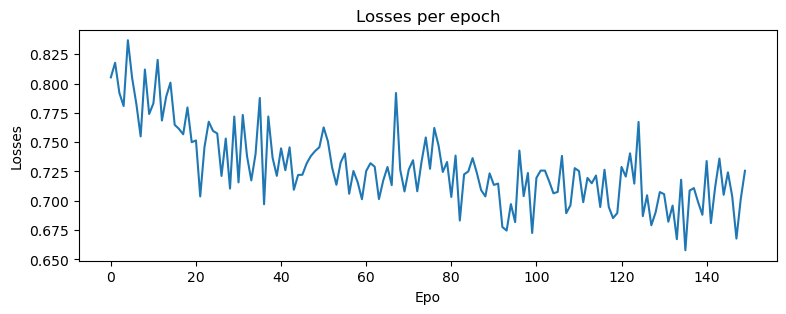

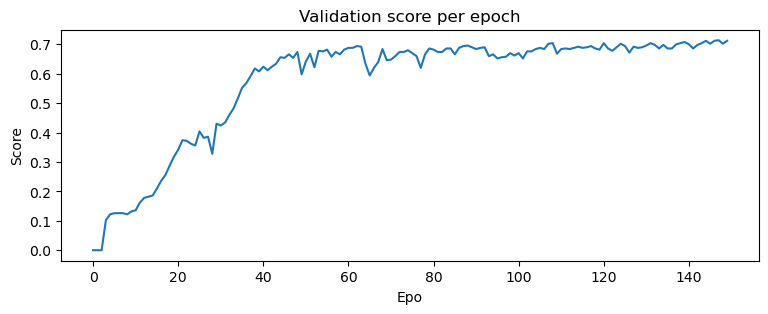

In [44]:
show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

Лоссы очень сильно скачат

### lr=default
### epo=150

Поменяю lr на default'ный

val score 0.7279999852180481
train 0.9770
valid 0.7280
test_ 0.7480


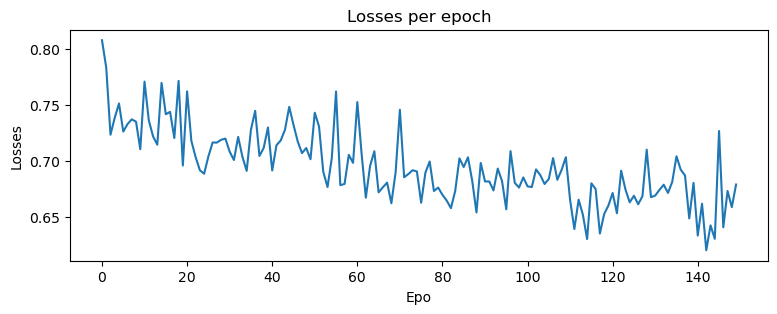

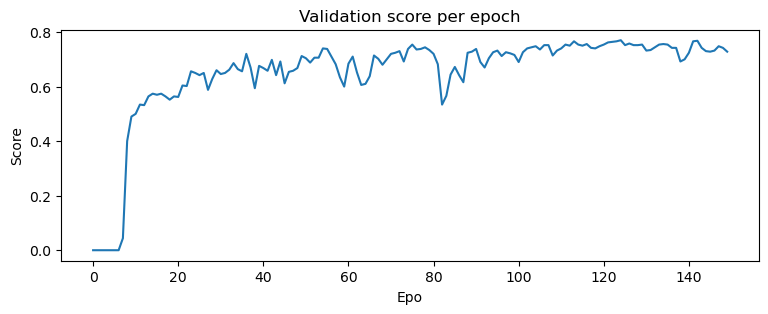

In [50]:
model_lr = SegNet().to(device)
max_epochs = 150
optim = torch.optim.Adam(model_lr.parameters())
losses, val_scores = train(model_lr, optim, bce_loss, max_epochs, data_tr, data_val, show_plots=False)
model_full_score(model_lr, ds_dict, show_plots=False, smooth_amout=0)
show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

Значения примерно те же после нескольких прогонов

### AdamW | lr=3e-4 | epo=150

val score 0.7120000123977661
train 0.9640
valid 0.7120
test_ 0.7000


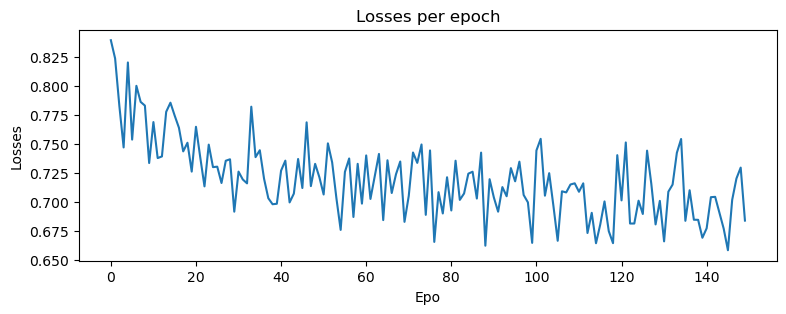

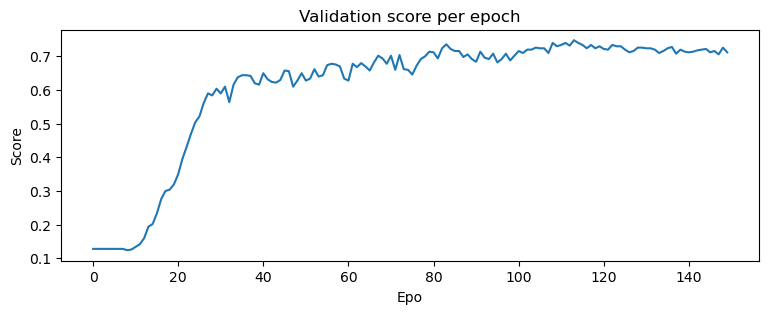

In [51]:
model_lr = SegNet().to(device)
max_epochs = 150
optim = torch.optim.AdamW(model_lr.parameters(), lr=3e-4)

losses, val_scores = train(model_lr, optim, bce_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_lr, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

Ничего особо не изменилось

### Smooth=1 | Adam | lr=3e-4 | epo=100

val score 0.7179999947547913
train 0.9650
valid 0.7080
test_ 0.7020


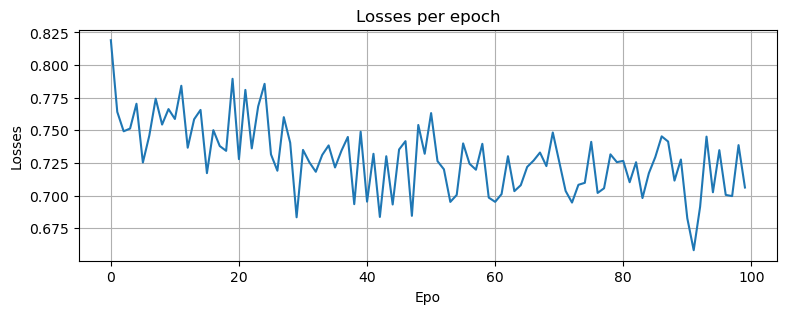

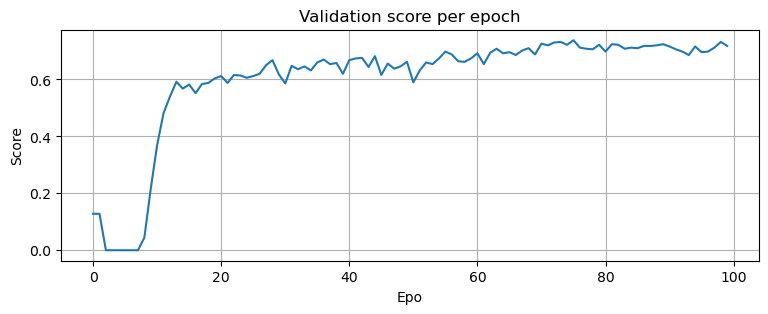

In [70]:
model_sm = SegNet().to(device)
max_epochs = 100
optim = torch.optim.Adam(model_sm.parameters(), lr=3e-4)

losses, val_scores = train(model_sm, optim, bce_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_sm, ds_dict, show_plots=False, smooth_amout=1)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

### Smooth=2 | Adam | lr=3e-4 | epo=100

val score 0.6780000627040863
train 0.9490
valid 0.7240
test_ 0.7020


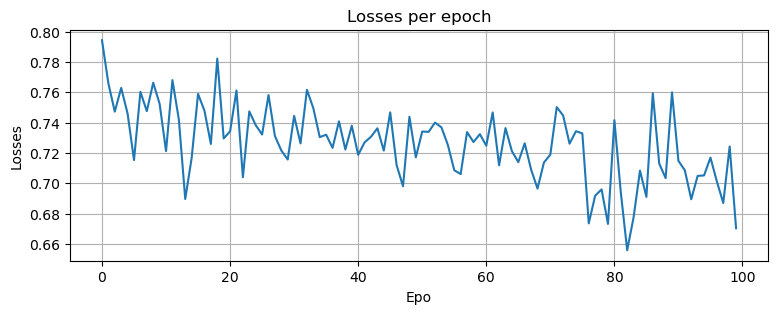

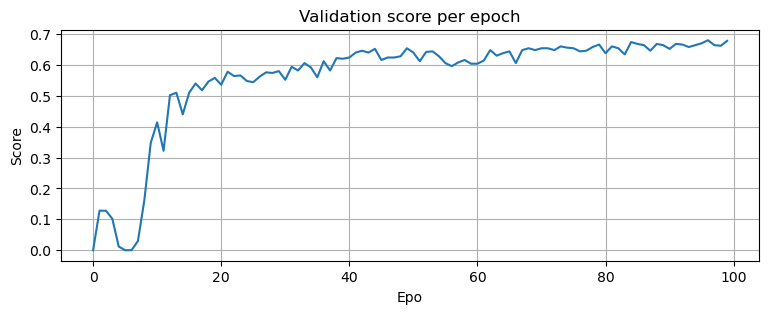

In [76]:
model_sm = SegNet().to(device)
max_epochs = 100
optim = torch.optim.Adam(model_sm.parameters(), lr=3e-4)

losses, val_scores = train(model_sm, optim, bce_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_sm, ds_dict, show_plots=False, smooth_amout=3)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

Сглаживание неоднозначно влияет 

### SegNet + nn.BCELoss 

In [82]:
def TorchBCEWrapper(y_true, y_pred):
    criterion = nn.BCELoss()
    loss = criterion(torch.sigmoid(y_pred), y_true)
    return loss

val score 0.6739999651908875
train 0.8980
valid 0.6740
test_ 0.7040


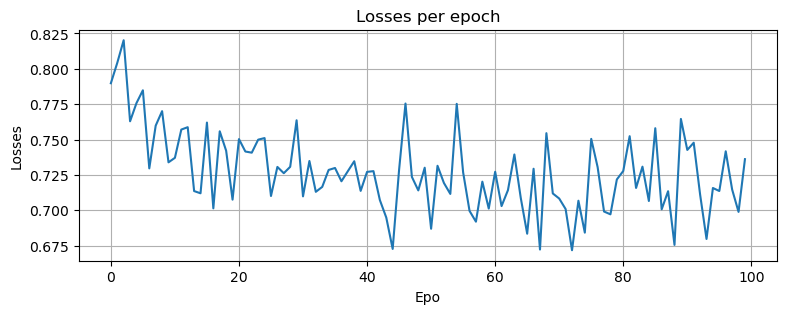

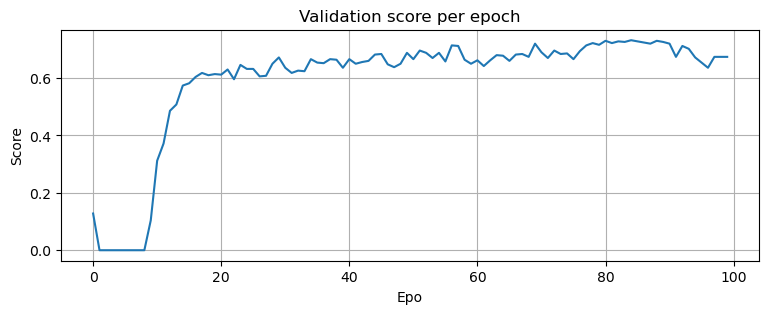

In [83]:
model_sm = SegNet().to(device)
max_epochs = 100
optim = torch.optim.Adam(model_sm.parameters(), lr=3e-4)


losses, val_scores = train(model_sm, optim, TorchBCEWrapper, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_sm, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

## SegNet + diceloss

In [61]:
model_dice = SegNet().to(device)

val score 0.7139999866485596
train 0.9960
valid 0.7140
test_ 0.7160


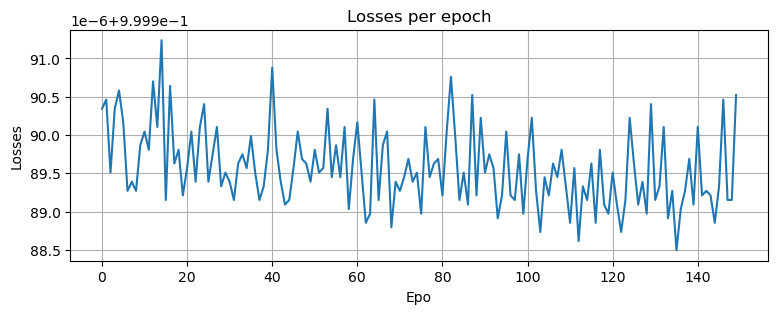

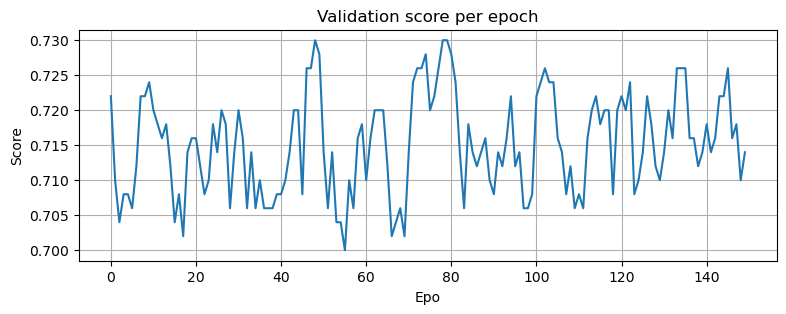

In [85]:
max_epochs = 150
optim = torch.optim.Adam(model_dice.parameters(), lr=3e-4)

losses, val_scores = train(model_dice, optim, dice_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_dice, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

...///

### SegNet + diceloss + Smooth=2

val score 0.6079999804496765
train 0.8980
valid 0.6300
test_ 0.6920


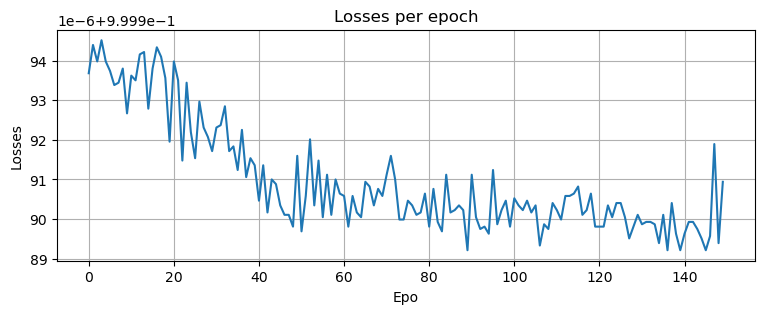

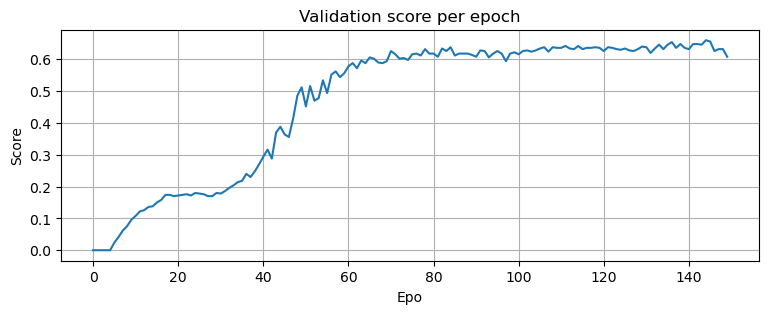

In [86]:
model_dice = SegNet().to(device)
max_epochs = 150
optim = torch.optim.Adam(model_dice.parameters(), lr=3e-4)

losses, val_scores = train(model_dice, optim, dice_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_dice, ds_dict, show_plots=False, smooth_amout=2)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

## SimpleSegNet

### SimpleSegNet code

In [63]:
class SimpleConvNormBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last_block=False):
        super().__init__()
        self.is_last_block = is_last_block

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)

        if not self.is_last_block:
            x = self.relu(x)
        return x

In [64]:
class SimpleSegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        #channels = 16
        self.enc_conv0 = SimpleConvNormBlock(3, 16)
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = SimpleConvNormBlock(16, 32)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = SimpleConvNormBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = SimpleConvNormBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = SimpleConvNormBlock(128, 128)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = SimpleConvNormBlock(128, 64)

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = SimpleConvNormBlock(64, 32)

        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = SimpleConvNormBlock(32, 16)

        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = SimpleConvNormBlock(16, 1, is_last_block=True)

    def forward(self, x):
        # encoder
        e, poll_ind0 = self.pool0(self.enc_conv0(x))
        e, poll_ind1 = self.pool1(self.enc_conv1(e))
        e, poll_ind2 = self.pool2(self.enc_conv2(e))
        e, poll_ind3 = self.pool3(self.enc_conv3(e))

        # bottleneck <1>
        b = self.bottleneck_conv(e)

        # decoder
        d = self.dec_conv0(self.upsample0(b, indices=poll_ind3))
        d = self.dec_conv1(self.upsample1(d, indices=poll_ind2))
        d = self.dec_conv2(self.upsample2(d, indices=poll_ind1))
        d = self.dec_conv3(self.upsample3(d, indices=poll_ind0))  # no activation
        return torch.sigmoid(d)

### SimpSegNet train and evaluating

#### SimpleSegNet + bceloss

val score 0.7000000178813934
train 0.9470
valid 0.7000
test_ 0.6900


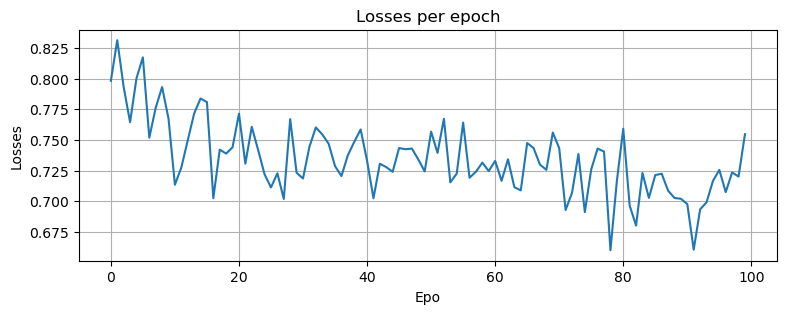

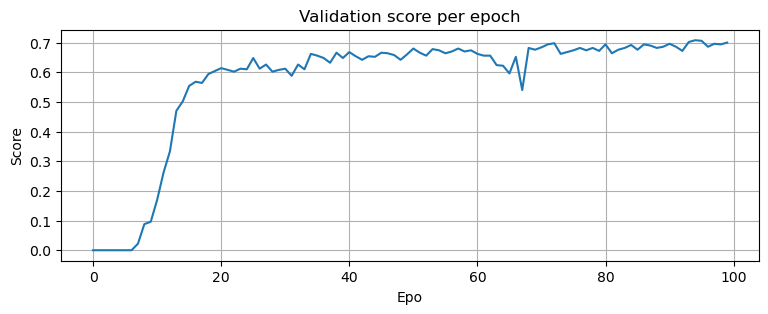

In [66]:
simple_seg_model = SimpleSegNet().to(device)

max_epochs = 100
optim = torch.optim.Adam(simple_seg_model.parameters(), lr=3e-4)

losses, val_scores = train(simple_seg_model, optim, bce_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(simple_seg_model, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

model_full_score(simple_seg_model, ds_dict, show_plots=False, smooth_amout=0)

#### SimpleSegNet + diceloss

val score 0.6519999802112579
train 0.8160
valid 0.6520
test_ 0.6620


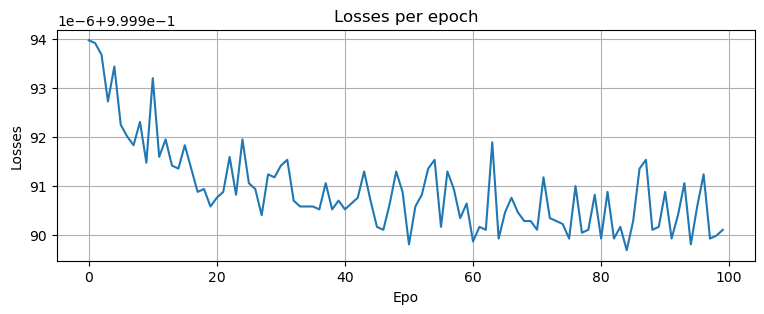

In [87]:
simple_dice_seg_model = SimpleSegNet().to(device)

max_epochs = 100
optim = torch.optim.Adam(simple_dice_seg_model.parameters(), lr=3e-4)

losses, val_scores = train(simple_dice_seg_model, optim, dice_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(simple_dice_seg_model, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')

#### Вывод

### Focal Loss

In [78]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):

    summand1 = torch.pow((1 - y_pred), gamma) * y_real * torch.log(y_pred + eps)
    summand2 = (1 - y_pred) * torch.log(1 - y_pred + eps)

    loss = -torch.sum(summand1 + summand2) / y_pred.size(0)
    #y_pred =  # hint: torch.clamp # чет я не понял зачем это, но когда словлю ошибку пойму
    #print(summand1)
    #print(summand2)
    return loss


In [79]:
class FocalLoss:
    def __init__(self, gamma = 2):
        self.gamma = gamma
    def __call__(self, y_real, y_pred):

        return focal_loss(y_real, y_pred, gamma=self.gamma)

### SegNet + FocalLoss

#### SegNet + FocalLoss + gamma=2

val score 0.6960000097751617
train 0.8200
valid 0.6960
test_ 0.6700


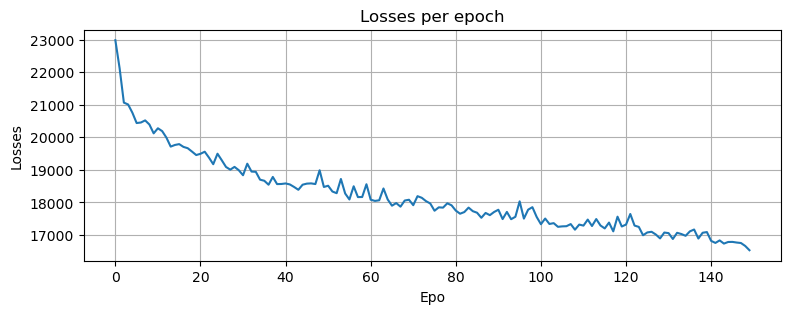

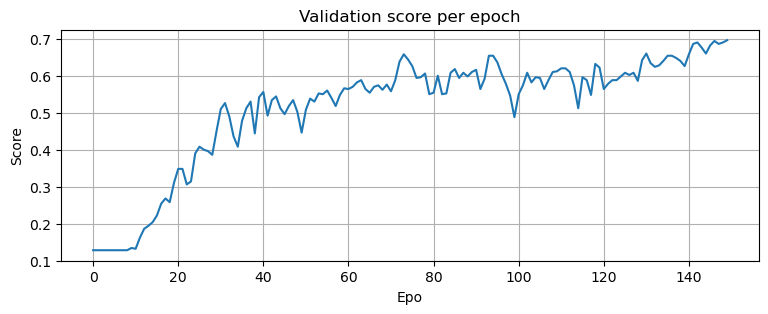

In [92]:
model_focal = SegNet().to(device)

loss = FocalLoss()

max_epochs = 150
optim = torch.optim.Adam(model_focal.parameters(), lr=3e-4)

losses, val_scores = train(model_focal, optim, loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_focal, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

#### SegNet + FocalLoss + gamma=4

val score 0.6559999883174896
train 0.8500
valid 0.6560
test_ 0.6920


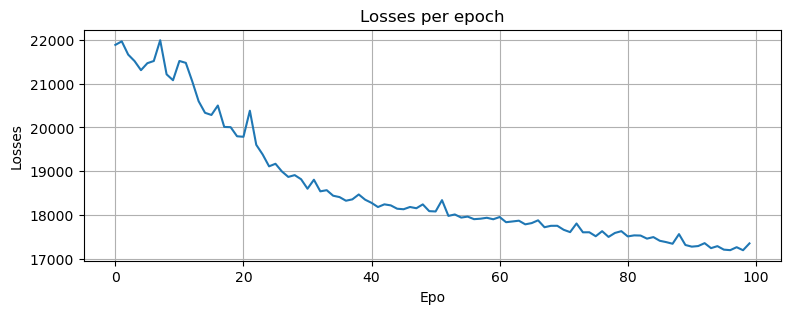

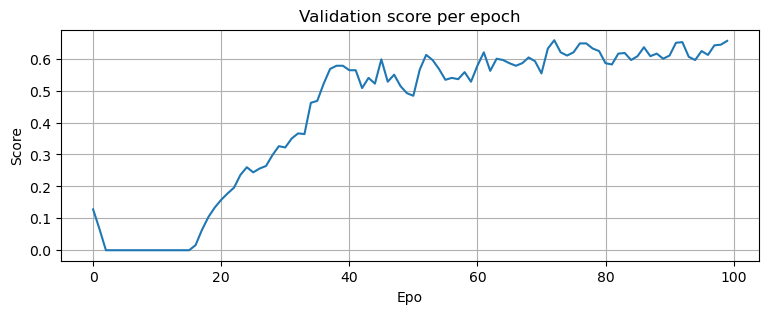

In [91]:
model_focal_4 = SegNet().to(device)

loss = FocalLoss(gamma=4)

max_epochs = 100
optim = torch.optim.Adam(model_focal_4.parameters(), lr=3e-4)

losses, val_scores = train(model_focal_4, optim, loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_focal_4, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

#### SegNet + FocalLoss + gamma=6

val score 0.6879999935626984
train 0.8920
valid 0.6880
test_ 0.6900


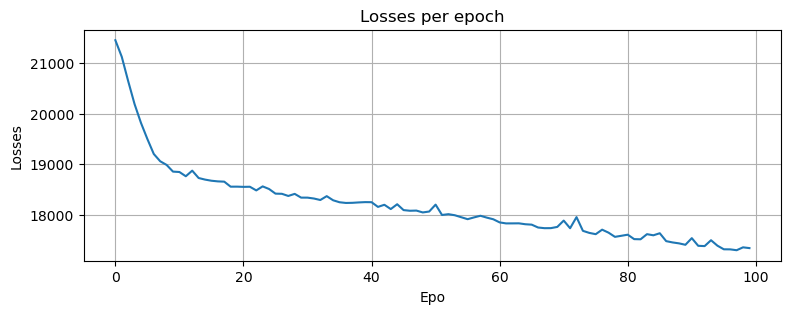

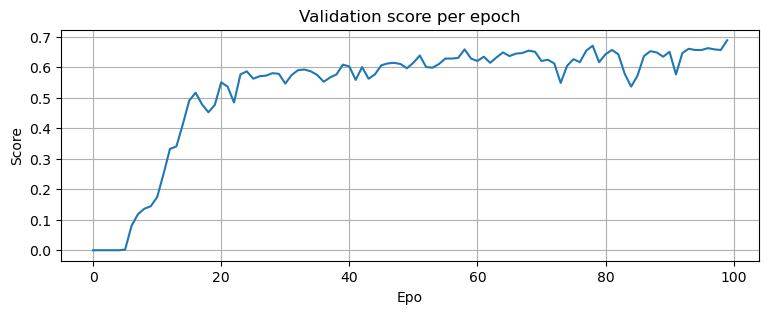

In [89]:
model_focal_6 = SegNet().to(device)

loss = FocalLoss(gamma=6)

max_epochs = 100
optim = torch.optim.Adam(model_focal_6.parameters(), lr=3e-4)

losses, val_scores = train(model_focal_6, optim, loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_focal_6, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

#### SegNet + FocalLoss + gamma=1.3

val score 0.5900000035762787
train 0.7150
valid 0.5900
test_ 0.5840


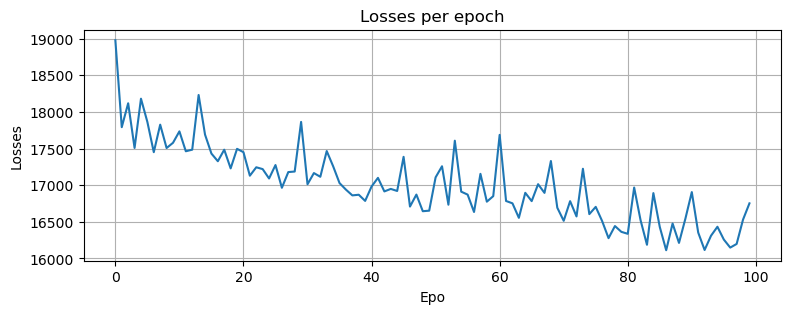

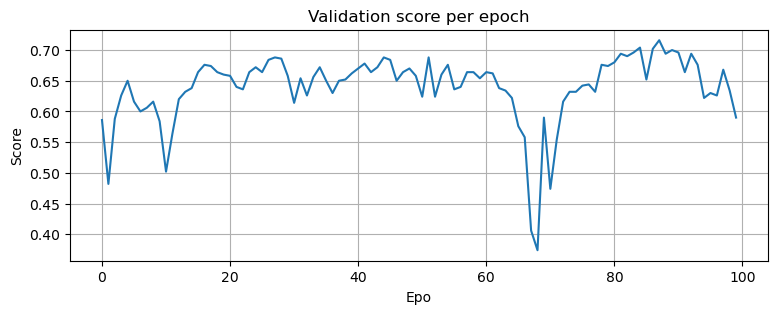

In [90]:
model_focal_15 = SegNet().to(device)

loss = FocalLoss(gamma=1.5)

max_epochs = 100
optim = torch.optim.Adam(model_focal_6.parameters(), lr=3e-4)

losses, val_scores = train(model_focal_6, optim, loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_focal_6, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

### Total Variation

In [93]:

def total_variation(image):
    """
    Вычисляет Total Variation (TV) на изображении.

    Args:
        image (torch.Tensor): Изображение, представленное в виде тензора (batch_size, channels, height, width).

    Returns:
        torch.Tensor: Значение Total Variation.
    """
    # Вычисляем разницу между соседними пикселями по горизонтали и вертикали
    horizontal_diff = image[:, :, :, :-1] - image[:, :, :, 1:]
    vertical_diff = image[:, :, :-1, :] - image[:, :, 1:, :]

    # Суммируем абсолютные значения разницы
    tv = torch.sum(torch.abs(horizontal_diff)) + torch.sum(torch.abs(vertical_diff))

    return tv

wrapper to use loss func and tv together

In [94]:
class LossPlusTV:
    def __init__(self, loss_func, alpha_loss, alpha_tv):
        self.loss = loss_func
        self.alpha_loss = alpha_loss
        self.alpha_tv = alpha_tv

    def __call__(self, y_real, y_pred):
        loss = self.loss(y_real=y_real, y_pred=y_pred)
        tv = total_variation(y_pred)
        #print('loss', self.alpha_loss * loss)
        #print('tv', self.alpha_tv*tv)
        return self.alpha_loss * loss + self.alpha_tv * tv


### SegNet + Dice + TV

#### SegNet + Dice + TV + alpha_loss=5, alpha_tv=0.000_000_1

val score 0.7440000474452972
train 0.9460
valid 0.7440
test_ 0.7720


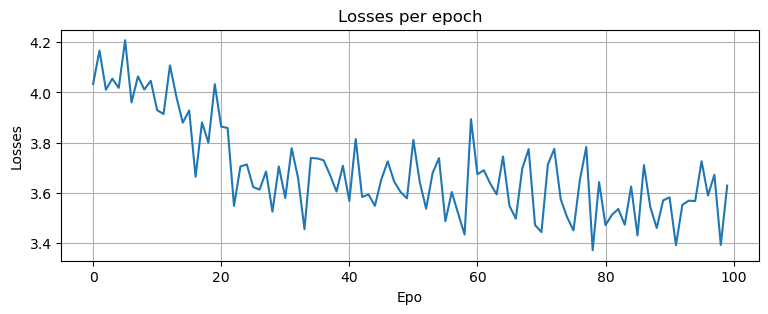

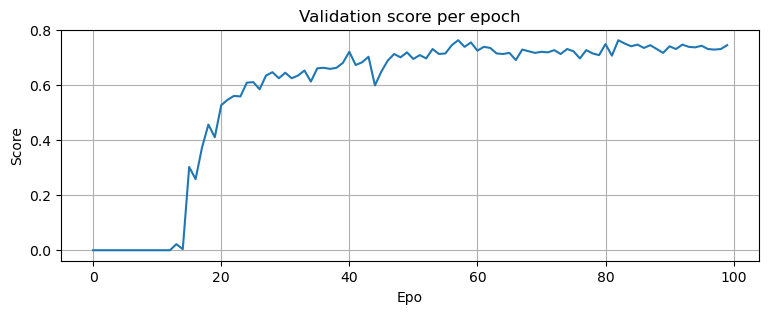

In [97]:
model_dice_tv = SegNet().to(device)

dice_tv_los = LossPlusTV(bce_loss, alpha_loss=5, alpha_tv=0.000_000_1)

max_epochs = 100
optim = torch.optim.Adam(model_dice_tv.parameters(), lr=3e-4)

losses, val_scores = train(model_dice_tv, optim, dice_tv_los, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_dice_tv, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

#### SegNet + Dice + TV + alpha_loss=1, alpha_tv=0.000_000_1

val score 0.7199999690055847
train 0.8840
valid 0.7200
test_ 0.7160


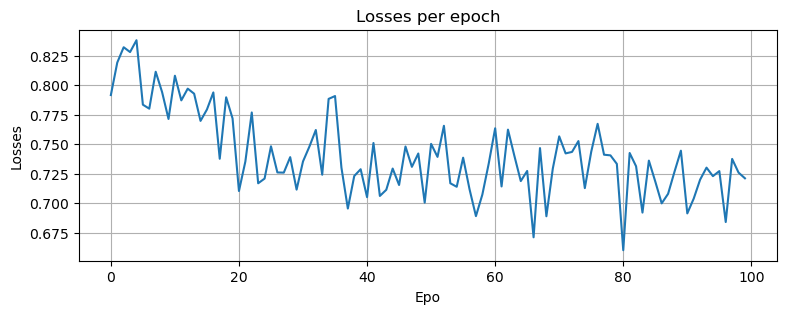

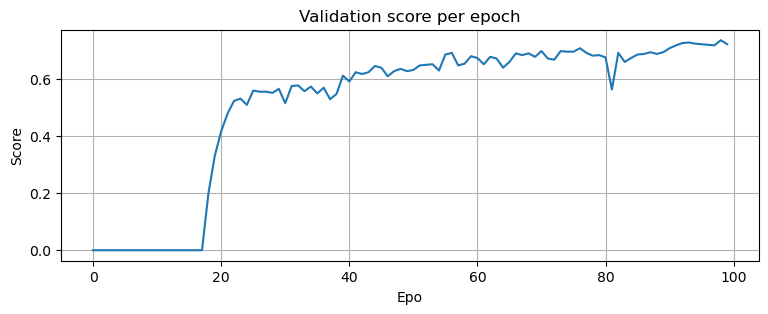

In [98]:
model_dice_tv2 = SegNet().to(device)

dice_tv_los = LossPlusTV(bce_loss, alpha_loss=1, alpha_tv=0.000_000_1)


max_epochs = 100
optim = torch.optim.Adam(model_dice_tv2.parameters(), lr=3e-4)

losses, val_scores = train(model_dice_tv2, optim, dice_tv_los, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(model_dice_tv2, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

## U-Net

### U-net skipconnection = sum

In [99]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = ConvNormBlock(3, 16)
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = ConvNormBlock(16, 32)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = ConvNormBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = ConvNormBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = ConvNormBlock(128, 128)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = ConvNormBlock(128, 64)

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = ConvNormBlock(64, 32)

        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = ConvNormBlock(32, 16)

        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = ConvNormBlock(16, 1, is_last_block=True)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e, poll_ind0 = self.pool0(e0)

        e1 = self.enc_conv1(e)
        e, poll_ind1 = self.pool1(e1)

        e2 = self.enc_conv2(e)
        e, poll_ind2 = self.pool2(e2)

        e3 = self.enc_conv3(e)
        e, poll_ind3 = self.pool3(e3)

        # bottleneck <1>
        b = self.bottleneck_conv(e)

        # decoder
        d = self.dec_conv0(self.upsample0(b, indices=poll_ind3) + e3)
        d = self.dec_conv1(self.upsample1(d, indices=poll_ind2) + e2)
        d = self.dec_conv2(self.upsample2(d, indices=poll_ind1) + e1)
        d = self.dec_conv3(self.upsample3(d, indices=poll_ind0) + e0)  # no activation
        return torch.sigmoid(d)

In [100]:
unet_sum_model = UNet().to(device)

val score 0.7380000054836273
train 0.9350
valid 0.7380
test_ 0.7240


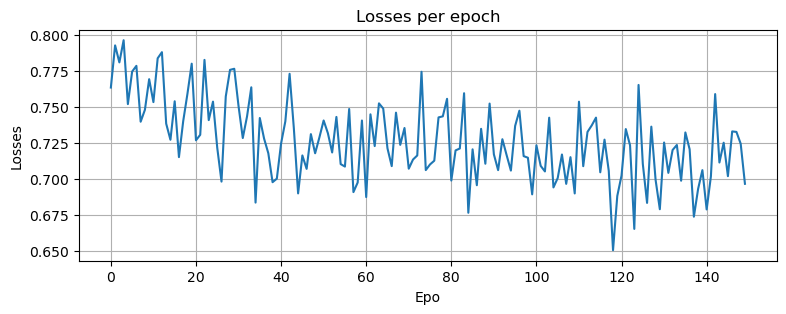

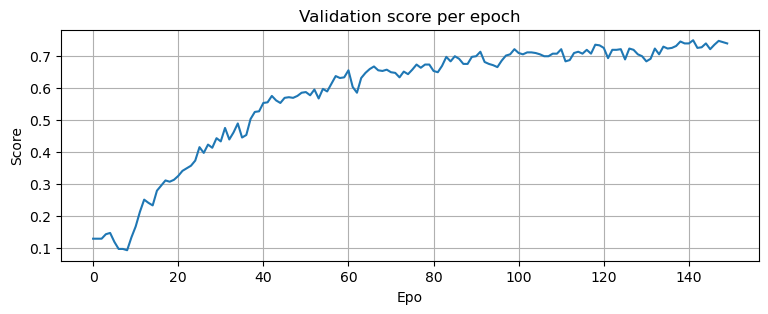

In [101]:

max_epochs = 150
optim = torch.optim.Adam(unet_sum_model.parameters(), lr=3e-4)

losses, val_scores = train(unet_sum_model, optim, bce_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(unet_sum_model, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

### U-net skipconnection = concatenation

In [102]:
class UNetCon(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = ConvNormBlock(3, 16)
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = ConvNormBlock(16, 32)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = ConvNormBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = ConvNormBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = ConvNormBlock(128, 128)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = ConvNormBlock(128*2, 64)

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = ConvNormBlock(64*2, 32)

        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = ConvNormBlock(32*2, 16)

        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = ConvNormBlock(16*2, 1, is_last_block=True)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e, poll_ind0 = self.pool0(e0)

        e1 = self.enc_conv1(e)
        e, poll_ind1 = self.pool1(e1)

        e2 = self.enc_conv2(e)
        e, poll_ind2 = self.pool2(e2)

        e3 = self.enc_conv3(e)
        e, poll_ind3 = self.pool3(e3)

        # bottleneck <1>
        b = self.bottleneck_conv(e)

        # decoder
        d= torch.cat((self.upsample0(b, indices=poll_ind3), e3), dim=1)
        d = self.dec_conv0(d)

        d = torch.cat((self.upsample1(d, indices=poll_ind2), e2), dim=1)
        d = self.dec_conv1(d)

        d = torch.cat((self.upsample2(d, indices=poll_ind1), e1), dim=1)
        d = self.dec_conv2(d)

        d = torch.cat((self.upsample3(d, indices=poll_ind0), e0), dim=1)
        d = self.dec_conv3(d)  # no activation
        return torch.sigmoid(d)

In [104]:
unet_con_model = UNetCon().to(device)

val score 0.7540000081062317
train 0.9900
valid 0.7540
test_ 0.7300


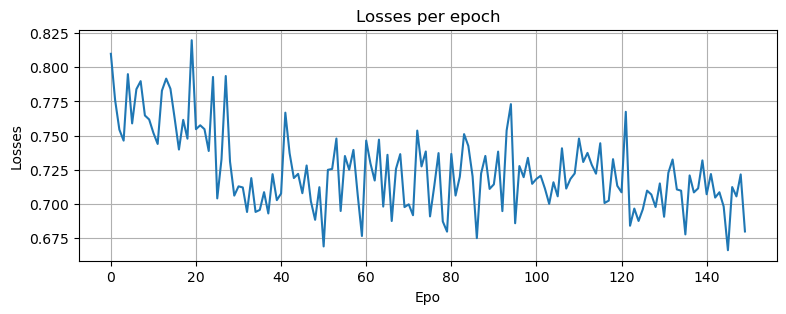

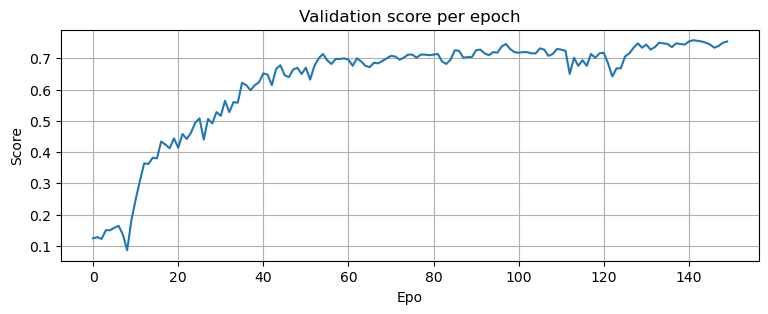

In [105]:

max_epochs = 150
optim = torch.optim.Adam(unet_con_model.parameters(), lr=3e-4)

losses, val_scores = train(unet_con_model, optim, bce_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(unet_con_model, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

### U-net 2 (concat + conv_stride=2 + trans_conv_stride=2) 
 skipconnection = concatenation + max-pooling = convolutions с stride=2 + upsampling = transpose-convolutions с stride=2.

In [106]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = ConvNormBlock(3, 16)
        self.pool0 = nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=2)  # 256 -> 128

        self.enc_conv1 = ConvNormBlock(16, 32)
        self.pool1 = nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=2) # 128 -> 64

        self.enc_conv2 = ConvNormBlock(32, 64)
        self.pool2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2) # 64 -> 32

        self.enc_conv3 = ConvNormBlock(64, 128)
        self.pool3 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = ConvNormBlock(128, 128)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.dec_conv0 = ConvNormBlock(128*2, 64)

        self.upsample1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0) # 32 -> 64
        self.dec_conv1 = ConvNormBlock(64*2, 32)

        self.upsample2 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0)  # 64 -> 128
        self.dec_conv2 = ConvNormBlock(32*2, 16)

        self.upsample3 = nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = ConvNormBlock(16*2, 1, is_last_block=True)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e = self.pool0(e0)

        e1 = self.enc_conv1(e)
        e = self.pool1(e1)

        e2 = self.enc_conv2(e)
        e = self.pool2(e2)

        e3 = self.enc_conv3(e)
        e= self.pool3(e3)

        # bottleneck <1>
        b = self.bottleneck_conv(e)

        # decoder

        d= torch.cat((self.upsample0(b), e3), dim=1)
        d = self.dec_conv0(d)
        #print('e3',e2.shape, 'ups', self.upsample1(d).shape)
        d = torch.cat((self.upsample1(d), e2), dim=1)
        d = self.dec_conv1(d)

        d = torch.cat((self.upsample2(d), e1), dim=1)
        d = self.dec_conv2(d)

        d = torch.cat((self.upsample3(d), e0), dim=1)
        d = self.dec_conv3(d)  # no activation
        return torch.sigmoid(d)

In [107]:
unet2_model = UNet2().to(device)

val score 0.8019999861717224
train 0.9610
valid 0.8020
test_ 0.7580


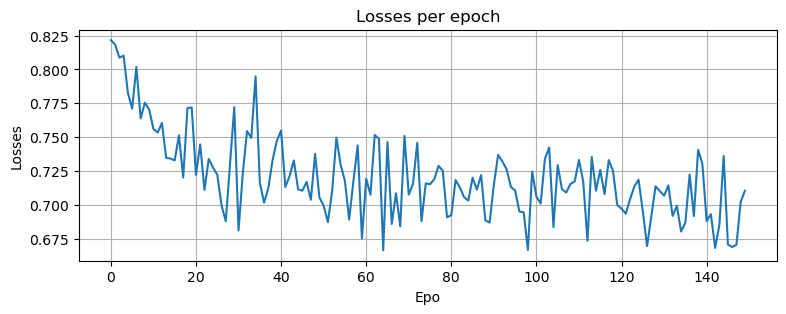

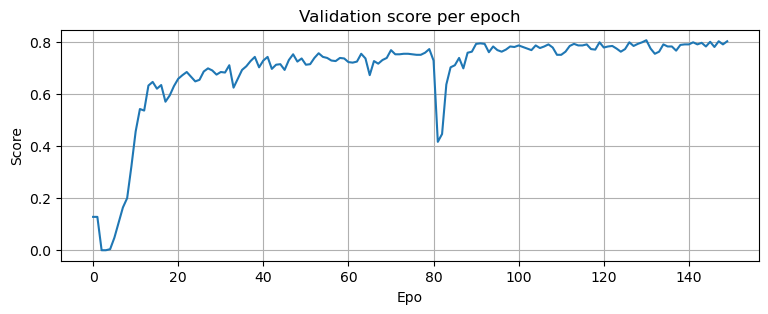

In [108]:
max_epochs = 150
optim = torch.optim.Adam(unet2_model.parameters(), lr=3e-4)

losses, val_scores = train(unet2_model, optim, bce_loss, max_epochs, data_tr, data_val, show_plots=False)

model_full_score(unet2_model, ds_dict, show_plots=False, smooth_amout=0)

show_plot(losses, title='Losses per epoch', xlabel='Epo', ylabel='Losses')
show_plot(val_scores, title='Validation score per epoch', xlabel='Epo', ylabel='Score')

In [ ]:
ma_opt = torch.optim.Adam(unet2_model.parameters(), lr=3e-4)
max_epochs = 150
losses, val_acc = train(unet2_model, ma_opt, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
model_full_score(unet2_model, ds_dict, show_plots=False, smooth_amout=0)